# Systematic Scan Gibbs Sampling Algorithm

The Systematic Scan Gibbs Sampling Algorithm updates each dimension in the order in which they appear in the representation of the state, at each update using the current values of the other dimensions of the state like this:

$$
1. X_{1}^{(t)} \sim \pi_{X_{j}|X_{-j}}(\cdot|X_{2}^{(t)}, \dots  X_{d}^{(t-1)}) \\
...\\
j. X_{j}^{(t)} \sim \pi_{X_{j}|X_{-j}}(\cdot|X_{1}^{(t)}, \dots , X_{j-1}^{(t)}, X_{j+1}^{(t-1)},\dots X_{d}^{(t-1)}) \\
...\\
d. X_{d}^{(t)} \sim \pi_{X_{d}|X_{-j}}(\cdot|X_{1}^{(t)}, \dots X_{d-1}^{(t-1)})
$$

In this notebook we will show some of implementations (good and bad examles) of the Systematic Scan Gibbs Sampling algorithm 

In [1]:
# Import required libraries
import seqgibbs

import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

## A good example

Let $X := (X_1,X_2) \sim N(\mu, \Sigma)$ where $\mu = (\mu_1, \mu_2)$ and covariance matrix 
$
\Sigma = \begin{pmatrix}
\sigma^2_1 & \rho \\
\rho & \sigma^2_2
\end{pmatrix}
$
.



The Gibbs sampler proceeds as follows in this case with the following conditional probabilities:

(a) Sample $X_1^{(t)} \sim N (\mu_1 +\rho/\sigma_2^2(X_2^{(t−1)}−\mu_2), \sigma_1^2−\rho^2/\sigma_2^2)$

(b) Sample $X_2^{(t)} \sim N (\mu_2 +\rho/\sigma_1^2(X_1^{(t)}−\mu_1), \sigma_2^2−\rho^2/\sigma_1^2)$.

Firstly, we take the case when the dimesnions of the target distribution are perfectly correlated, i.e. $\rho = 1$.

In [45]:
# Set correlation coefficient
rho = 1

# Set other parameters of the target distribution
mu1, mu2, var1, var2 = (0, 0.5 , 2, 1)

# Create now functions that return the parameters for the unidimensional simulator
# for X1 and X2 in terms of the current position.
# The sampler has a normal distribution shape so these parameters need
# to be the mean and variance of the dsitribution.
def first_fun(x):
    return mu1 + rho/var2 *(x - mu2), var1 - rho**2/var2

def second_fun(x):
    return mu2 + rho/var1 *(x - mu1), var2 - rho**2/var1

# Now create the unidimensional samplers for each of the two dimensions X1 and X2
first_sampler = seqgibbs.OneDimSampler(scipy.stats.norm.rvs, first_fun)
second_sampler = seqgibbs.OneDimSampler(scipy.stats.norm.rvs, second_fun)

# Now create wrapper Systematic Scan Gibbs sampler starting at the default position (origin)
# to which we then feed the two unidimensional samplers we constructed.
sys_sampler = seqgibbs.SysGibbsAlgo(num_dim=2, initial_state=np.array([0., 0.]))

sys_sampler.add_1_d_sampler(first_sampler)
sys_sampler.add_1_d_sampler(second_sampler)

# Run 200 complete scan cycles of the algorithm and save the chain
chain1 = sys_sampler.run(num_cycles=200)

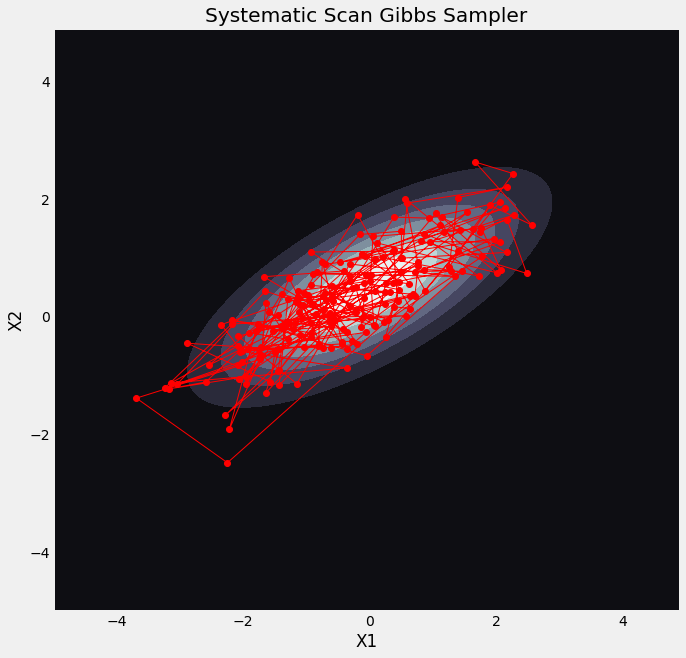

In [47]:
# Plot target distribution in white and grey
from matplotlib import style
style.use('fivethirtyeight')
from scipy.stats import multivariate_normal

x,y = np.mgrid[-5:5:.1, -5:5:0.1]

pos = np.dstack((x, y))
rv = multivariate_normal([mu1, mu2], [[var1, rho], [rho, var2]])
fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(111)
ax0.contourf(x, y, rv.pdf(pos), cmap=plt.cm.bone)

# Separate the 1st and second dimensions of the states in the chain and
# plot the Gibbs sampler steps
gibbs_x1 = np.asarray(chain1)[:,0].tolist()
gibbs_x2 = np.asarray(chain1)[:,1].tolist()

plt.plot(gibbs_x1, gibbs_x2, marker='o', c='r', linewidth=1)

plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Systematic Scan Gibbs Sampler')
plt.show()

## A bad example

Traget distribution
$\pi(x, y) \propto \mathbb{1}_{[−1,0]×[−1,0]∪[0,1]×[0,1]}(x, y)$

Then, the conditional distributions for both dimensions are 

The reason why the algorithm fails to retrieve the correct distribution in this case is because the target distribution violates the positivity condition: